## Setting up HDDM model

In [1]:
import pandas as pd
import hddm

rawData = hddm.load_csv('study1nonadaptive.csv')
data = rawData[rawData['sure'] == 0]
data['choice'] = data['choice'] ^ 1
data['loss'] = data['loss'] * (-1)
data.rename(columns = {'id':'subj_idx', 'choice':'response', 'win':'gain'}, inplace = True)

/anaconda3/lib/python2.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)
/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/anaconda3/lib/python2.7/site-packages/pandas/core/frame.py:40

In [2]:
data.head()

,subj_idx,trial,rt,response,gain,loss,sure
1,1,2,3.790270,1,12.0,-7.50,0.0
3,1,4,2.003780,1,10.0,-15.00,0.0
4,1,5,3.993464,0,2.0,-3.00,0.0
7,1,8,4.908444,0,10.0,-12.50,0.0
8,1,9,1.064644,1,12.0,-3.75,0.0


In [6]:
m = hddm.models.HDDMRegressor(data, ['v ~ gain + loss'], include=('z'), group_only_regressors=False)

Adding these covariates:
['v_Intercept', 'v_gain', 'v_loss']


In [7]:
m.find_starting_values()

/anaconda3/lib/python2.7/site-packages/scipy/optimize/optimize.py:1934: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/anaconda3/lib/python2.7/site-packages/scipy/optimize/optimize.py:1935: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1


In [8]:
import os
modelName = 'full'
if not os.path.exists('savedModels/{}'.format(modelName)):
    os.makedirs('savedModels/{}'.format(modelName))

m.sample(5000, burn=1000, dbname='savedModels/{}/db_{}'.format(modelName, modelName), db='pickle')

 [-----------------100%-----------------] 5001 of 5000 complete in 14754.0 sec

In [9]:
m.save('savedModels/{}/{}'.format(modelName, modelName))

In [3]:
modelName = 'full'
m = hddm.load('savedModels/{}/{}'.format(modelName, modelName))

## Model parameters

In [10]:
m.print_stats()
m.print_stats(fname='savedModels/{}/{}_stats.txt'.format(modelName, modelName))

                           mean         std         2.5q          25q         50q         75q       97.5q       mc err
a                       2.70186    0.103659      2.50955      2.63312     2.69822     2.76767     2.91306   0.00209988
a_std                  0.632708   0.0825226       0.4943      0.57527    0.622158    0.679687    0.818952   0.00208663
a_subj.1                2.39157    0.104816      2.19573      2.32044     2.38939     2.45922     2.60889   0.00321314
a_subj.2                2.09463   0.0740656      1.95344      2.04372     2.09378     2.14574     2.24009   0.00188225
a_subj.3                2.87265     0.10248      2.68296      2.80253     2.86957      2.9381     3.08152   0.00231885
a_subj.4                2.04154   0.0913359      1.87528      1.97776     2.03968     2.09879     2.23213   0.00230216
a_subj.5                2.26492   0.0822488      2.10626       2.2091     2.26315     2.31861     2.43226   0.00200745
a_subj.6                 2.2625    0.072225     

$\lambda$

In [4]:
import numpy as np
modelParamsDF = m.nodes_db
modelParamsDF.to_csv('savedModels/{}/{}_nodes.csv'.format(modelName, modelName))

In [5]:
# group level mean of lambda
groupLevelMeanOfLambda = modelParamsDF.loc['v_loss', 'mean']/modelParamsDF.loc['v_gain', 'mean']
print("group level mean of lamdba is: ", round(groupLevelMeanOfLambda, 3))

# 95% CI for beta_G, beta_L
print("2.5% percentile for beta_L: ", round(modelParamsDF.loc['v_loss', '2.5q'], 3))
print("97.5% percentile for beta_G: ", round(modelParamsDF.loc['v_gain', '97.5q'], 3))

('group level mean of lamdba is: ', 1.44)
('2.5% percentile for beta_L: ', 0.138)
('97.5% percentile for beta_G: ', 0.129)


In [8]:
# how many participants have beta_L > beta_G, how many have the 95% CI greater?
# participant level mean (SD) of lambda
numSubjects = 39
numLambdaMean = 0
numLambdaCI = 0
allParticipantLambdas = []

for subjectIndex in range(1, numSubjects+1):
    beta_gain = modelParamsDF.loc['v_gain_subj.{}'.format(subjectIndex), 'mean']
    beta_loss = modelParamsDF.loc['v_loss_subj.{}'.format(subjectIndex), 'mean']
    beta_L_lowerBound = modelParamsDF.loc['v_loss_subj.{}'.format(subjectIndex), '2.5q']
    beta_G_upperBound = modelParamsDF.loc['v_gain_subj.{}'.format(subjectIndex), '97.5q']
    
    if beta_loss > beta_gain:
        numLambdaMean += 1
        
    if beta_L_lowerBound > beta_G_upperBound:
        numLambdaCI += 1
        
    lambdaForThisParticipant = beta_loss/beta_gain
    allParticipantLambdas.append(lambdaForThisParticipant)

print("Number of people with beta_L > beta_G = ", round(numLambdaMean, 3))
# print("Number of people with 95% CI of beta_L > beta_G = ", numLambdaCI)
print("Average lambda over all individuals = {} (SD = {})".format(round(np.mean(allParticipantLambdas), 3), round(np.std(allParticipantLambdas), 3)))

('Number of people with beta_L > beta_G = ', 32.0)
Average lambda over all individuals = 1.513 (SD = 0.591)


In [9]:
print("beta_L mean:", round(modelParamsDF.loc['v_loss', 'mean'], 3))
print("beta_L 2.5q:", round(modelParamsDF.loc['v_loss', '2.5q'], 3))
print("beta_L 97.5q:", round(modelParamsDF.loc['v_loss', '97.5q'], 3))
print("beta_L median", round(modelParamsDF.loc['v_loss', '50q'], 3))
print("beta_L SD", round(modelParamsDF.loc['v_loss', 'std'], 3))

print("beta_G mean:", round(modelParamsDF.loc['v_gain', 'mean'], 3))
print("beta_G 2.5q:", round(modelParamsDF.loc['v_gain', '2.5q'], 3))
print("beta_G 97.5q:", round(modelParamsDF.loc['v_gain', '97.5q'], 3))
print("beta_G median", round(modelParamsDF.loc['v_gain', '50q'], 3))
print("beta_G SD", round(modelParamsDF.loc['v_gain', 'std'], 3))

('beta_L mean:', 0.16)
('beta_L 2.5q:', 0.138)
('beta_L 97.5q:', 0.184)
('beta_L median', 0.16)
('beta_L SD', 0.012)
('beta_G mean:', 0.111)
('beta_G 2.5q:', 0.094)
('beta_G 97.5q:', 0.129)
('beta_G median', 0.111)
('beta_G SD', 0.009)


$\gamma$

In [10]:
# meanA = modelParamsDF.loc['a', 'mean']
# print("mean value of threshold: ", meanA)

# 95 CI interval
Z_CI_lowerBound = (modelParamsDF.loc['z'.format(subjectIndex), '2.5q'] - 0.5)*2
Z_CI_upperBound = (modelParamsDF.loc['z'.format(subjectIndex), '97.5q'] - 0.5)*2
print("confidence interval of gamma: ", round(Z_CI_lowerBound, 3), round(Z_CI_upperBound, 3))

('confidence interval of gamma: ', -0.185, -0.085)


In [11]:
# mean gamma across all participants, how many participants have 95% CI of gamma strictly negative
allParticipantsZ = []
countGammaMean = 0
countGammaCI = 0

for participantIndex in range(1, numSubjects+1):
    a_participant = modelParamsDF.loc['a_subj.{}'.format(participantIndex), 'mean']
    z_participant = (modelParamsDF.loc['z_subj.{}'.format(participantIndex), 'mean'] - 0.5)*2
    allParticipantsZ.append(z_participant)
    z_upperBound_participant = (modelParamsDF.loc['z_subj.{}'.format(participantIndex), '97.5q'] - 0.5)*2
    
    if z_upperBound_participant < 0:
        countGammaCI += 1
        
    if z_participant < 0:
        countGammaMean += 1
    
mean_Z = np.mean(allParticipantsZ)
SD_Z = np.std(allParticipantsZ)
print("Mean value of pre-valuation bias across all participants: {} (SD = {})".format(round(mean_Z, 3), round(SD_Z, 3)))
print("Number of participants with negative gamma: ", round(countGammaMean, 3))
print("Number of participants with 95% CI of gamma negative: ", round(countGammaCI, 3))

Mean value of pre-valuation bias across all participants: -0.13 (SD = 0.197)
('Number of participants with negative gamma: ', 28.0)
('Number of participants with 95% CI of gamma negative: ', 23.0)


In [12]:
print("gamma mean:", round((modelParamsDF.loc['z', 'mean'] - 0.5)*2, 3))
print("gamma 2.5q:", round((modelParamsDF.loc['z', '2.5q'] - 0.5)*2, 3))
print("gamma 97.5q:", round((modelParamsDF.loc['z', '97.5q'] - 0.5)*2, 3))
print("gamma median", round((modelParamsDF.loc['z', '50q'] - 0.5)*2, 3))
print("gamma SD", round((modelParamsDF.loc['z', 'std'])*2, 3))

('gamma mean:', -0.135)
('gamma 2.5q:', -0.185)
('gamma 97.5q:', -0.085)
('gamma median', -0.135)
('gamma SD', 0.025)


$\alpha$

In [13]:
# group-level mean
print("Group-level mean of alpha is: ", round(modelParamsDF.loc['v_Intercept'.format(subjectIndex), 'mean'], 3))

# how many participants have mean and 95% CI negative?
allParticipantsAlphas = []
countAlphaMean = 0
countAlphaCI = 0

for participantIndex in range(1, numSubjects+1):
    alpha_participant = modelParamsDF.loc['v_Intercept_subj.{}'.format(participantIndex), 'mean']
    allParticipantsAlphas.append(alpha_participant)
    alpha_upperBound_participant = modelParamsDF.loc['v_Intercept_subj.{}'.format(participantIndex), '97.5q']
    
    if alpha_upperBound_participant < 0:
        countAlphaCI += 1
        
    if alpha_participant < 0:
        countAlphaMean += 1
        
mean_alpha = np.mean(allParticipantsAlphas)
SD_alpha = np.std(allParticipantsAlphas)
print("Mean value of fixed utility bias across all participants: {} ({})".format(round(mean_alpha, 3), round(SD_alpha, 3)))
print("Number of participants with negative alpha: ", round(countAlphaMean, 3))
print("Number of participants with 95% CI of alpha negative: ", round(countAlphaCI, 3))

('Group-level mean of alpha is: ', -0.179)
Mean value of fixed utility bias across all participants: -0.182 (0.511)
('Number of participants with negative alpha: ', 21.0)
('Number of participants with 95% CI of alpha negative: ', 15.0)


In [14]:
print("alpha mean:", round(modelParamsDF.loc['v_Intercept', 'mean'], 3))
print("alpha 2.5q:", round(modelParamsDF.loc['v_Intercept', '2.5q'], 3))
print("alpha 97.5q:", round(modelParamsDF.loc['v_Intercept', '97.5q'], 3))
print("alpha median", round(modelParamsDF.loc['v_Intercept', '50q'], 3))
print("alpha SD", round(modelParamsDF.loc['v_Intercept', 'std'], 3))

('alpha mean:', -0.179)
('alpha 2.5q:', -0.368)
('alpha 97.5q:', 0.013)
('alpha median', -0.18)
('alpha SD', 0.096)


$\theta$

In [15]:
print("theta mean:", round(modelParamsDF.loc['a', 'mean']/2, 3))
print("theta 2.5q:", round(modelParamsDF.loc['a', '2.5q']/2, 3))
print("theta 97.5q:", round(modelParamsDF.loc['a', '97.5q']/2, 3))
print("theta median", round(modelParamsDF.loc['a', '50q']/2, 3))
print("theta SD", round(modelParamsDF.loc['a', 'std']/2, 3))

('theta mean:', 1.351)
('theta 2.5q:', 1.255)
('theta 97.5q:', 1.457)
('theta median', 1.349)
('theta SD', 0.052)


$\tau$

In [16]:
print("tau mean:", round(modelParamsDF.loc['t', 'mean'], 3))
print("tau 2.5q:", round(modelParamsDF.loc['t', '2.5q'], 3))
print("tau 97.5q:", round(modelParamsDF.loc['t', '97.5q'], 3))
print("tau median", round(modelParamsDF.loc['t', '50q'], 3))
print("tau SD", round(modelParamsDF.loc['t', 'std'], 3))

('tau mean:', 0.427)
('tau 2.5q:', 0.35)
('tau 97.5q:', 0.527)
('tau median', 0.424)
('tau SD', 0.045)


# Correlation with rejection rates

In [21]:
groupedData = data.groupby("subj_idx")
allParticipants_p_accept = groupedData["response"].aggregate(np.mean).to_list()

In [22]:
from scipy.stats.stats import pearsonr
import seaborn as sns
from matplotlib import pyplot as plt

In [23]:
import matplotlib
matplotlib.rcParams.update({'font.size': 30})

('Pearson correlation between Lambda and P(Acceptance) is: ', (0.1554198695533134, 0.3447732912030397))


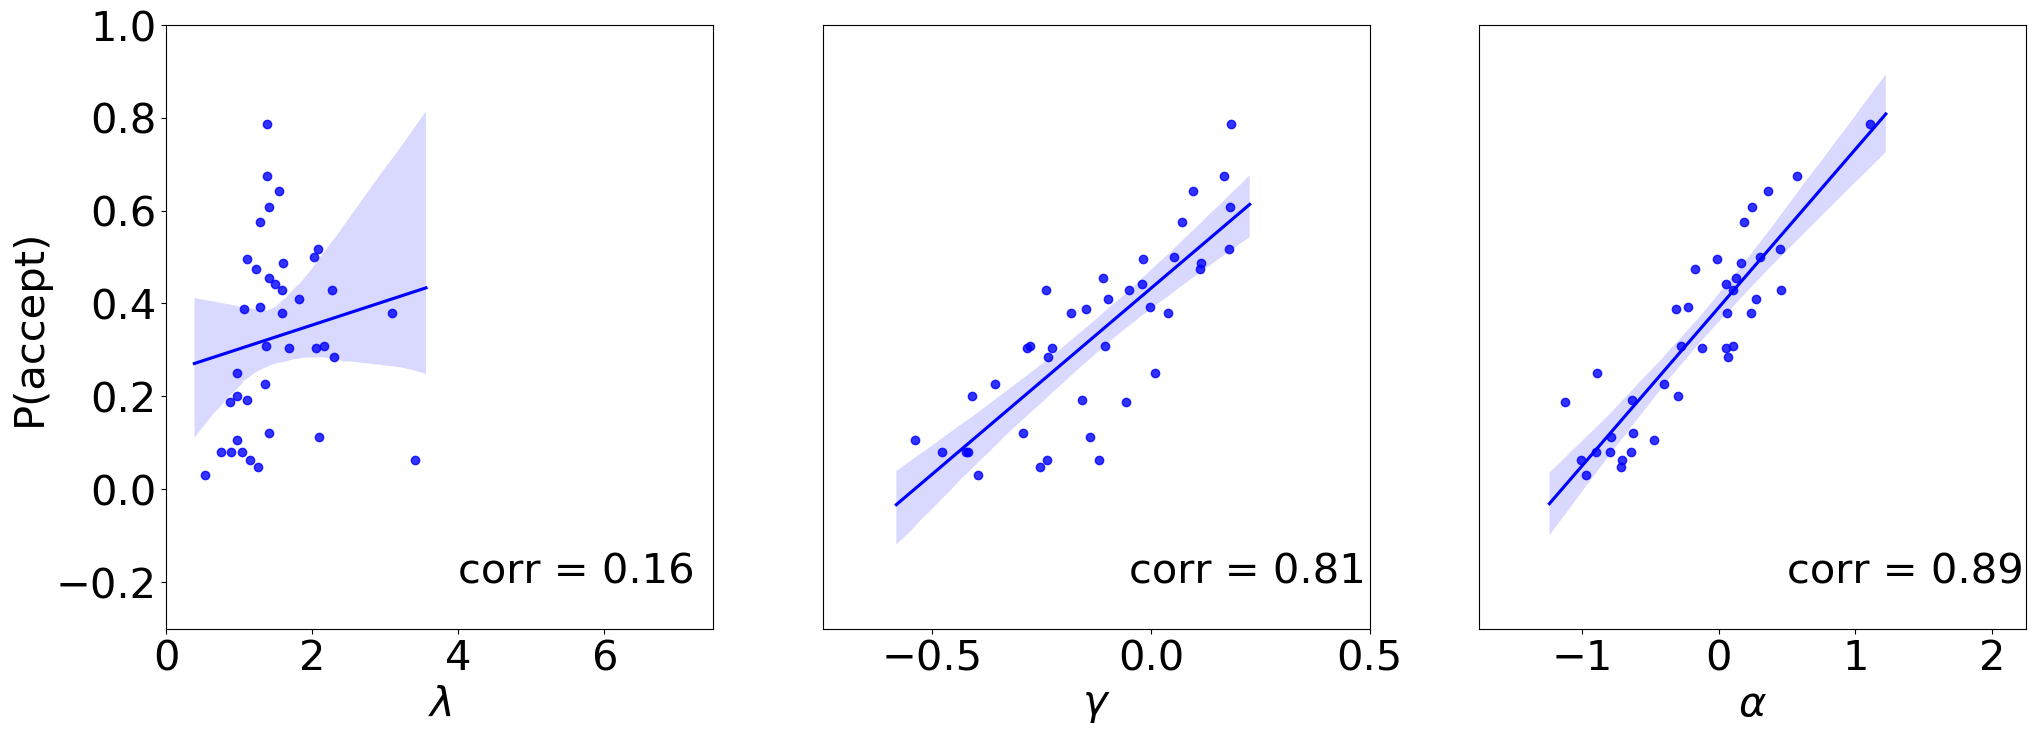

In [34]:
fig=plt.figure(figsize=(24,8), dpi= 100, facecolor='w', edgecolor='k')

ax1 = plt.subplot2grid(shape=(1,3), loc=(0,0), colspan=1)
sns.regplot(allParticipantLambdas, allParticipants_p_accept, color ='blue', ax=ax1)
ax1.set_xlabel(r"$\lambda$")
ax1.set_ylabel("P(accept)")
ax1.annotate("corr = {}".format(round(pearsonr(allParticipantLambdas, allParticipants_p_accept)[0], 2)), (4, -0.2))
ax1.set_xlim(0, 7.5)
ax1.set_ylim(-0.3, 1)

ax2 = plt.subplot2grid(shape=(1,3), loc=(0,1), colspan=1)
sns.regplot(allParticipantsZ, allParticipants_p_accept, color ='blue', ax=ax2)
ax2.set_xlabel(r"$\gamma$")
ax2.set_xlim(-0.75, 0.5)
ax2.set_ylim(-0.3, 1)
ax2.annotate("corr = {}".format(round(pearsonr(allParticipantsZ, allParticipants_p_accept)[0], 2)), (-0.05, -0.2))
# ax2.tick_params(axis='y', left=False)
ax2.set_yticks([])


ax3 = plt.subplot2grid(shape=(1,3), loc=(0,2), colspan=1)
sns.regplot(allParticipantsAlphas, allParticipants_p_accept, color ='blue', ax=ax3)
ax3.set_xlabel(r"$\alpha$")
ax3.set_xlim(-1.75, 2.25)
ax3.set_ylim(-0.3, 1)
ax3.annotate("corr = {}".format(round(pearsonr(allParticipantsAlphas, allParticipants_p_accept)[0], 2)), (0.5, -0.2))
ax3.set_yticks([])

print("Pearson correlation between Lambda and P(Acceptance) is: ", pearsonr(allParticipantLambdas, allParticipants_p_accept))
plt.savefig("fig/pAccept_corr.png", bbox_inches='tight')

('Pearson correlation between Lambda and P(Acceptance) is: ', (0.1554198695533134, 0.3447732912030397))


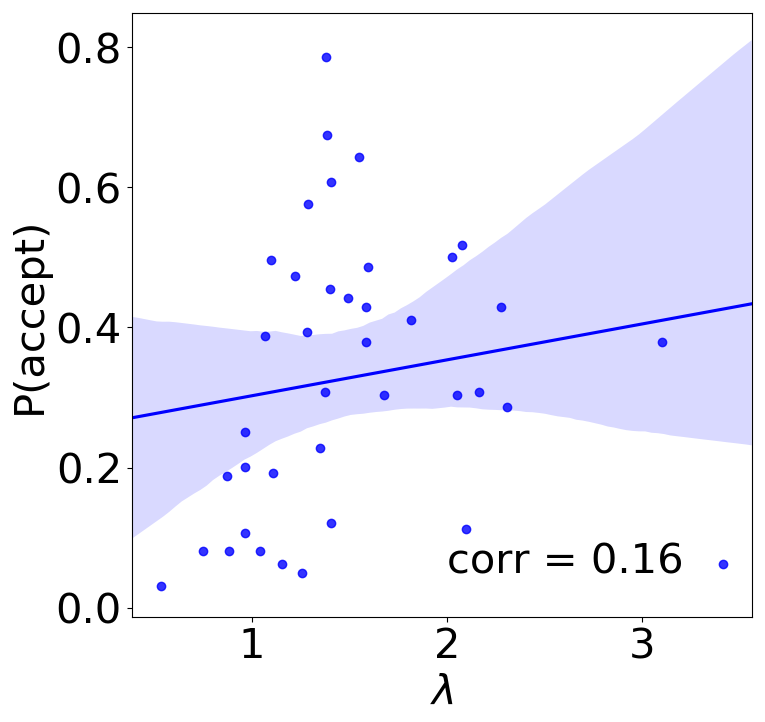

In [27]:
fig=plt.figure(figsize=(8,8), dpi= 100, facecolor='w', edgecolor='k')
sns.regplot(allParticipantLambdas, allParticipants_p_accept, color ='blue')
plt.xlabel(r"$\lambda$")
plt.ylabel("P(accept)")
plt.annotate("corr = {}".format(round(pearsonr(allParticipantLambdas, allParticipants_p_accept)[0], 2)), (2, 0.05))
print("Pearson correlation between Lambda and P(Acceptance) is: ", pearsonr(allParticipantLambdas, allParticipants_p_accept))
plt.savefig("fig/lambda_PAccept_corr.png", bbox_inches='tight')

('Pearson correlation between gamma and P(Acceptance) is: ', (0.8095702081952095, 4.377360678306558e-10))


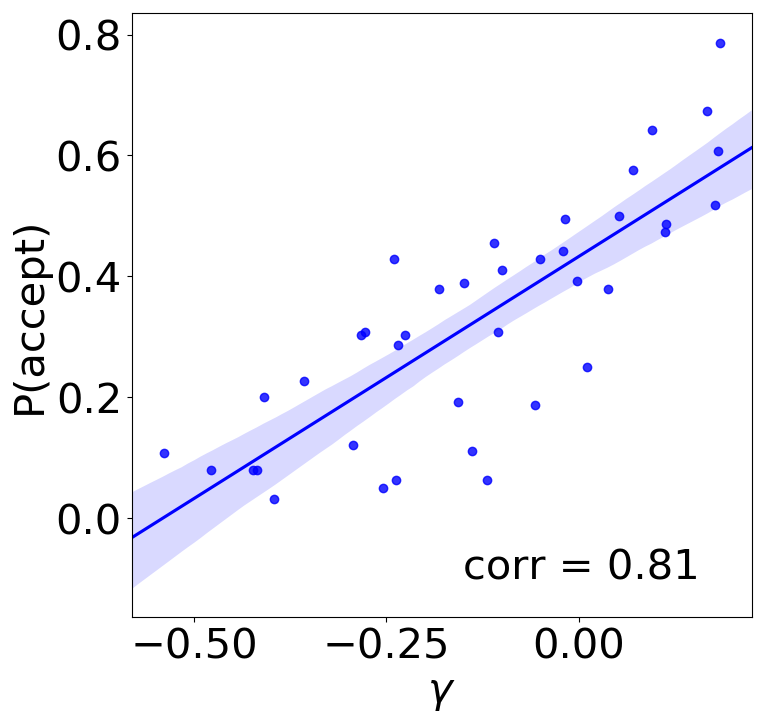

In [29]:
fig=plt.figure(figsize=(8,8), dpi= 100, facecolor='w', edgecolor='k')
sns.regplot(allParticipantsZ, allParticipants_p_accept, color ='blue')
plt.xlabel(r"$\gamma$")
plt.ylabel("P(accept)")
plt.annotate("corr = {}".format(round(pearsonr(allParticipantsZ, allParticipants_p_accept)[0], 2)), (-0.15, -0.1))
print("Pearson correlation between gamma and P(Acceptance) is: ", pearsonr(allParticipantsZ, allParticipants_p_accept))
plt.savefig("fig/gamma_PAccept_corr.png", bbox_inches='tight')

('Pearson correlation between alpha and P(Acceptance) is: ', (0.8941503500362119, 1.7769074665372277e-14))


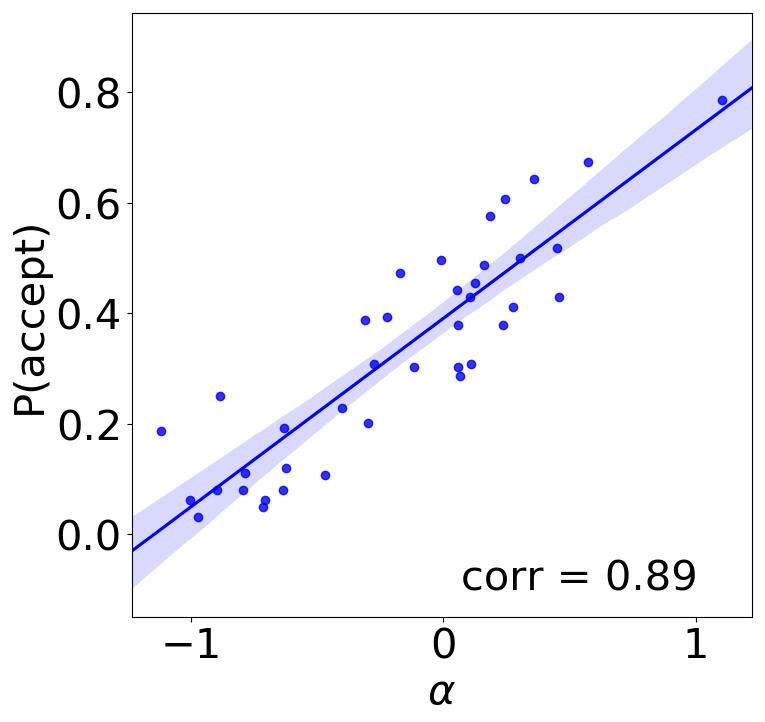

In [32]:
fig=plt.figure(figsize=(8,8), dpi= 100, facecolor='w', edgecolor='k')
sns.regplot(allParticipantsAlphas, allParticipants_p_accept, color ='blue')
plt.xlabel(r"$\alpha$")
plt.ylabel("P(accept)")
plt.annotate("corr = {}".format(round(pearsonr(allParticipantsAlphas, allParticipants_p_accept)[0], 2)), (0.07, -0.1))
print("Pearson correlation between alpha and P(Acceptance) is: ", pearsonr(allParticipantsAlphas, allParticipants_p_accept))
plt.savefig("fig/alpha_PAccept_corr.png", bbox_inches='tight')

# Correlation with lambda (traditional method -- computed using logistic regression)

In [18]:
import matplotlib
matplotlib.rcParams.update({'font.size': 30})

In [35]:
from sklearn.linear_model import LogisticRegression
indicesToAnalyze = []

for participantIndex in range(numSubjects):
    if allParticipants_p_accept[participantIndex] != 0:
        indicesToAnalyze.append(participantIndex)

def computeParticipantLambdaLR(subjectIndex):
    participantData = data[data['subj_idx'] == subjectIndex+1]
    X = participantData[['gain', 'loss']]
    y = participantData['response']
    classifier = LogisticRegression().fit(X, y)
    coefficients = classifier.coef_
    participantLambdaLR = coefficients[0][1]/coefficients[0][0]
    return participantLambdaLR

allParticipantLambdasLR = [computeParticipantLambdaLR(_) for _ in indicesToAnalyze]

/anaconda3/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


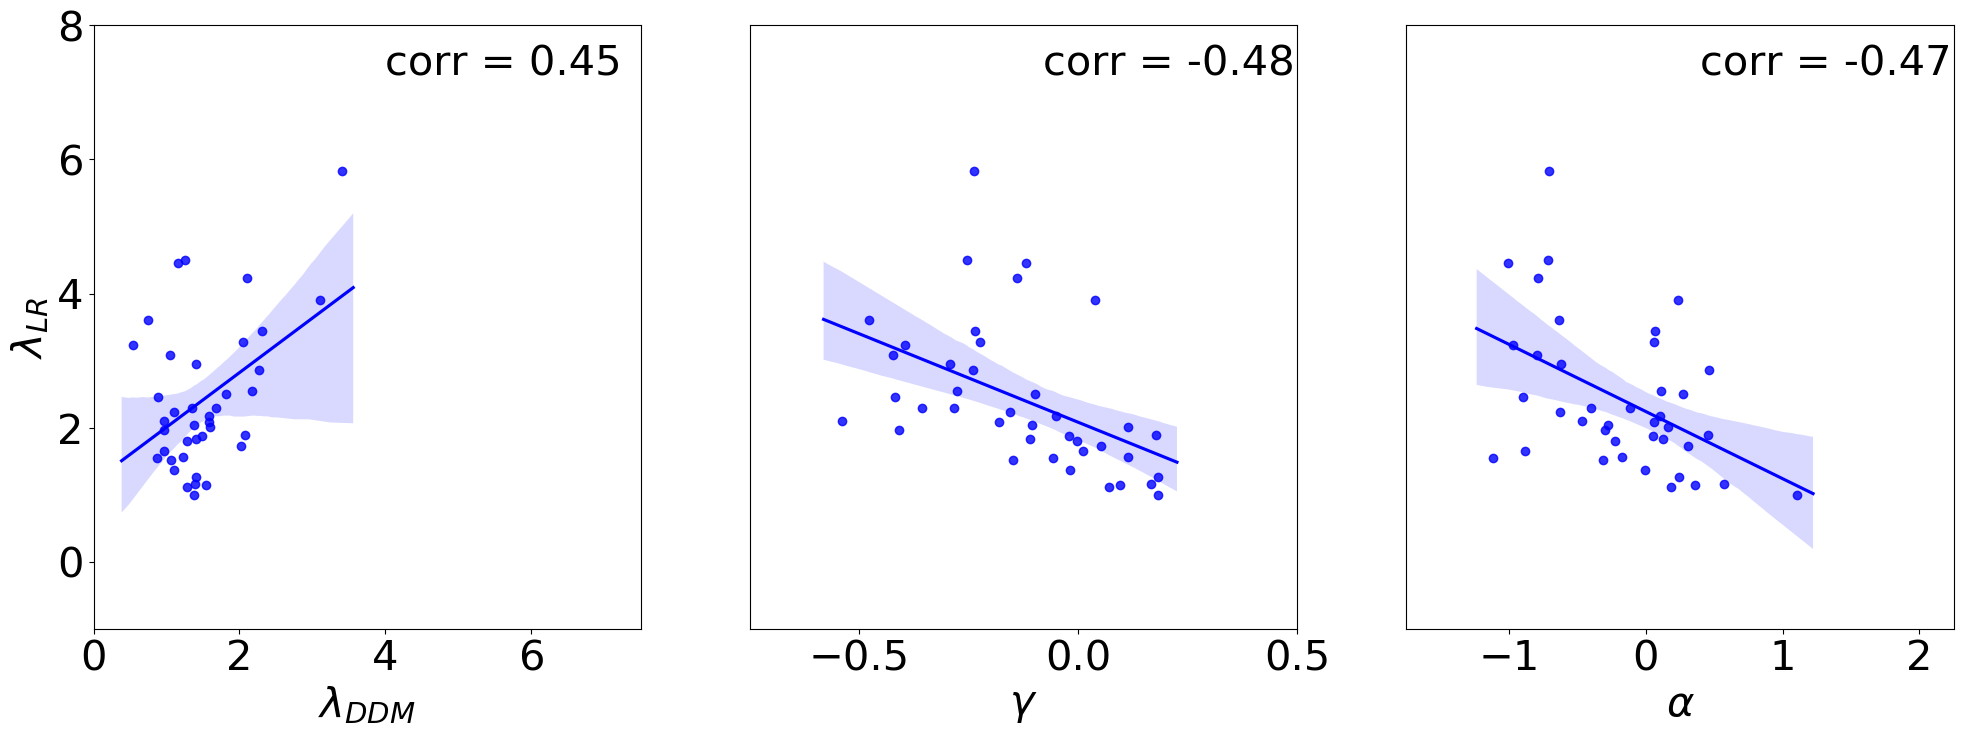

In [37]:
fig=plt.figure(figsize=(24,8), dpi= 100, facecolor='w', edgecolor='k')

lambdasToCorrelate = np.array(allParticipantLambdas)[indicesToAnalyze]
ax1 = plt.subplot2grid(shape=(1,3), loc=(0,0), colspan=1)
sns.regplot(lambdasToCorrelate, allParticipantLambdasLR, color ='blue', ax=ax1)
ax1.set_xlabel(r"$\lambda_{DDM}$")
ax1.set_ylabel(r"$\lambda_{LR}$")
ax1.annotate("corr = {}".format(round(pearsonr(lambdasToCorrelate, allParticipantLambdasLR)[0], 2)), (4, 7.25))
ax1.set_xlim(0, 7.5)
ax1.set_ylim(-1, 8)

gammasToCorrelate = np.array(allParticipantsZ)[indicesToAnalyze]
ax2 = plt.subplot2grid(shape=(1,3), loc=(0,1), colspan=1)
sns.regplot(gammasToCorrelate, allParticipantLambdasLR, color ='blue', ax=ax2)
ax2.set_xlabel(r"$\gamma$")
ax2.set_xlim(-0.75, 0.5)
ax2.set_ylim(-1, 8)
ax2.annotate("corr = {}".format(round(pearsonr(gammasToCorrelate, allParticipantLambdasLR)[0], 2)), (-0.08, 7.25))
# ax2.tick_params(axis='y', left=False)
ax2.set_yticks([])


alphasToCorrelate = np.array(allParticipantsAlphas)[indicesToAnalyze]
ax3 = plt.subplot2grid(shape=(1,3), loc=(0,2), colspan=1)
sns.regplot(alphasToCorrelate, allParticipantLambdasLR, color ='blue', ax=ax3)
ax3.set_xlabel(r"$\alpha$")
ax3.set_xlim(-1.75, 2.25)
ax3.set_ylim(-1, 8)
ax3.annotate("corr = {}".format(round(pearsonr(alphasToCorrelate, allParticipantLambdasLR)[0], 2)), (0.4, 7.25))
ax3.set_yticks([])

plt.savefig("fig/lambda_LR_corr.png", bbox_inches='tight')

('Pearson correlation between P(accept) and Logistic regression lambda is: ', (-0.7093442512665389, 4.3003161273344373e-07))


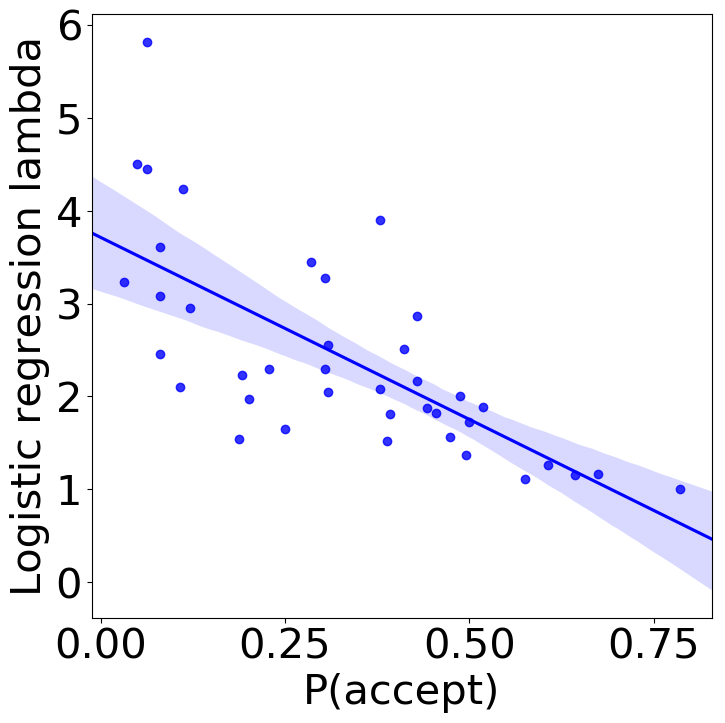

In [20]:
fig=plt.figure(figsize=(8,8), dpi= 100, facecolor='w', edgecolor='k')
pAcceptToCorrelate = np.array(allParticipants_p_accept)[indicesToAnalyze]
sns.regplot(pAcceptToCorrelate, allParticipantLambdasLR, color ='blue')
plt.xlabel("P(accept)")
plt.ylabel("Logistic regression lambda")
print("Pearson correlation between P(accept) and Logistic regression lambda is: ", pearsonr(pAcceptToCorrelate, allParticipantLambdasLR))

('Pearson correlation between DDM lambda and Logistic regression lambda is: ', (0.4454483775935429, 0.004486251970492456))


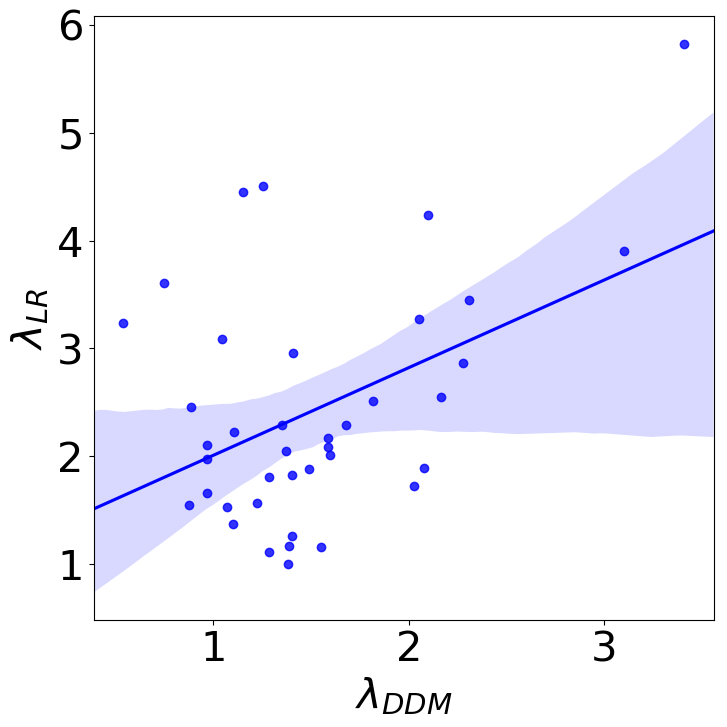

In [21]:
fig=plt.figure(figsize=(8,8), dpi= 100, facecolor='w', edgecolor='k')
lambdasToCorrelate = np.array(allParticipantLambdas)[indicesToAnalyze]
sns.regplot(lambdasToCorrelate, allParticipantLambdasLR, color ='blue')
plt.xlabel(r"$\lambda_{DDM}$")
plt.ylabel(r"$\lambda_{LR}$")
print("Pearson correlation between DDM lambda and Logistic regression lambda is: ", pearsonr(lambdasToCorrelate, allParticipantLambdasLR))

('Pearson correlation between gamma and Logistic regression lambda is: ', (-0.48227675725873603, 0.0018764238926001987))


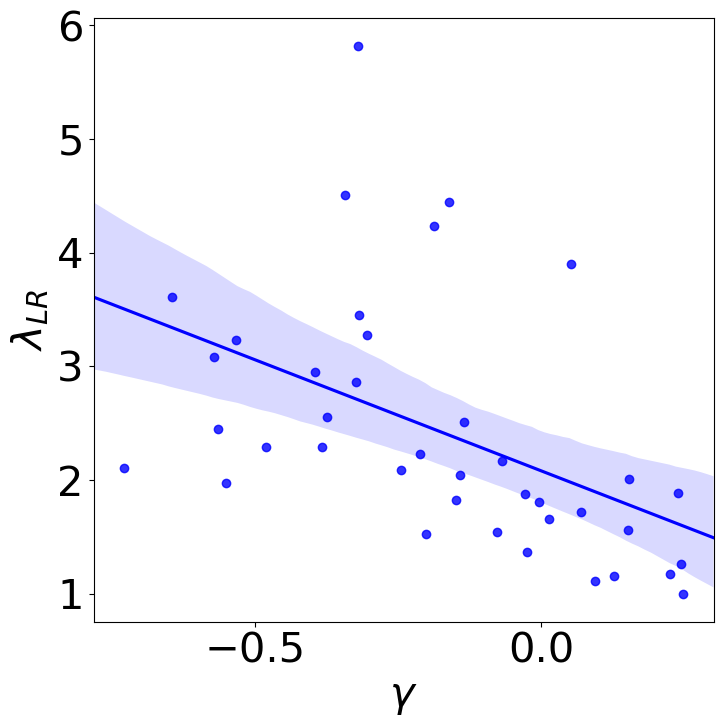

In [22]:
fig=plt.figure(figsize=(8,8), dpi= 100, facecolor='w', edgecolor='k')
gammasToCorrelate = np.array(allParticipantsZ)[indicesToAnalyze]
sns.regplot(gammasToCorrelate, allParticipantLambdasLR, color ='blue')
plt.xlabel(r"$\gamma$")
plt.ylabel(r"$\lambda_{LR}$")
print("Pearson correlation between gamma and Logistic regression lambda is: ", pearsonr(gammasToCorrelate, allParticipantLambdasLR))

('Pearson correlation between P(accept) and Logistic regression lambda is: ', (-0.4745771949221194, 0.0022695333539952114))


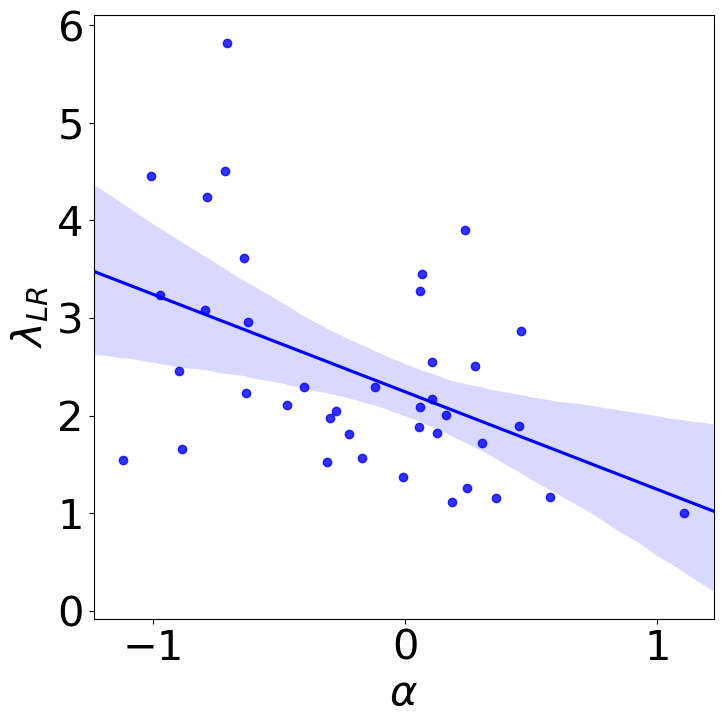

In [23]:
fig=plt.figure(figsize=(8,8), dpi= 100, facecolor='w', edgecolor='k')
alphasToCorrelate = np.array(allParticipantsAlphas)[indicesToAnalyze]
sns.regplot(alphasToCorrelate, allParticipantLambdasLR, color ='blue')
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\lambda_{LR}$")
print("Pearson correlation between P(accept) and Logistic regression lambda is: ", pearsonr(alphasToCorrelate, allParticipantLambdasLR))

## Standardized multiple regression $\lambda_{LR}$

In [32]:
from scipy import stats
import statsmodels.formula.api as smf
from scipy.stats.mstats import zscore
import pandas as pd

y = np.reshape(allParticipantLambdasLR, (-1, 1))
X = np.vstack((lambdasToCorrelate, gammasToCorrelate, alphasToCorrelate)).T
# X = np.vstack((allParticipantLambdas, allParticipantsZ, allParticipantsAlphas)).T

combined = np.hstack((y, zscore(X)))
df = pd.DataFrame(combined)
df.columns = ['y', 'x1', 'x2', 'x3']
df_z = df.select_dtypes(include=[np.number]).dropna()#.apply(stats.zscore)


formula = 'y ~ x1 + x2 + x3'
result = smf.ols(formula, data=df_z).fit()
result.summary()


# print(np.shape(y))
# print(np.shape(X))

# print(sm.OLS(zscore(y), zscore(X)).fit().summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.718
Method:                 Least Squares   F-statistic:                     33.25
Date:                Sun, 13 Dec 2020   Prob (F-statistic):           2.38e-10
Time:                        10:41:48   Log-Likelihood:                -31.951
No. Observations:                  39   AIC:                             71.90
Df Residuals:                      35   BIC:                             78.56
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.4250      0.093     26.133      0.000       2.237       2.613
x1             0.7829      0.100      7.793      0.000       0.579       0.987
x2            -0.3104      0.114     -2.719      0.010      -0.542      -0.079
x3            -0.6298      0.121     -5.205      0.000      -0.875      -0.384
==============================================================================
Omnibus:                       11.030   Durbin-Watson:                   2.139
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               10.559
Skew:                           1.062   Prob(JB):                      0.00510
Kurtosis:                       4.410   Cond. No.                         2.17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Simulate data from model

In [5]:
ppc_data = hddm.utils.post_pred_gen(m, samples=50, progress_bar=True)

 [------------------107%------------------] 42 of 39 complete in 9126.3 sec

In [6]:
import numpy as np
dataArray = np.array(data)
print(dataArray[:5, :])

def extractStakesFromParticipantIndex(participantIndex):
    participantData = dataArray[dataArray[:, 0] == participantIndex][:]
    participantStakes = participantData[:, 4:6]
    return participantStakes

[[  1.           2.           3.79026967   1.          12.
   -7.5          0.        ]
 [  1.           4.           2.00377995   1.          10.
  -15.           0.        ]
 [  1.           5.           3.99346406   0.           2.
   -3.           0.        ]
 [  1.           8.           4.90844364   0.          10.
  -12.5          0.        ]
 [  1.           9.           1.06464404   1.          12.
   -3.75         0.        ]]


In [7]:
import numpy as np

overallData = np.zeros((1, 5))

for (node, sample), sim_data in ppc_data.groupby(level=(0, 1)):
    print("-------")
    print("node: ", node)
    sim_data_array = np.asarray(sim_data)
    numTrials = np.shape(sim_data_array)[0]
    print("number of trials: ", numTrials)
    participantIndex = int(filter(str.isdigit, node))
    participantStakes = extractStakesFromParticipantIndex(participantIndex)
    participantIndexArray = np.full((numTrials, 1), participantIndex)
    responsesArray = np.zeros((numTrials, 1))
    responsesArray[sim_data_array[:, 0] > 0] = 1
    reactionTimesArray = np.abs(sim_data_array)
    sim_data_modified = np.hstack((participantIndexArray, responsesArray, reactionTimesArray, participantStakes))
    overallData = np.vstack((overallData, sim_data_modified))
    
print(np.shape(overallData))

-------
('node: ', 'wfpt.1')
('number of trials: ', 224)
-------
('node: ', 'wfpt.1')
('number of trials: ', 224)
-------
('node: ', 'wfpt.1')
('number of trials: ', 224)
-------
('node: ', 'wfpt.1')
('number of trials: ', 224)
-------
('node: ', 'wfpt.1')
('number of trials: ', 224)
-------
('node: ', 'wfpt.1')
('number of trials: ', 224)
-------
('node: ', 'wfpt.1')
('number of trials: ', 224)
-------
('node: ', 'wfpt.1')
('number of trials: ', 224)
-------
('node: ', 'wfpt.1')
('number of trials: ', 224)
-------
('node: ', 'wfpt.1')
('number of trials: ', 224)
-------
('node: ', 'wfpt.1')
('number of trials: ', 224)
-------
('node: ', 'wfpt.1')
('number of trials: ', 224)
-------
('node: ', 'wfpt.1')
('number of trials: ', 224)
-------
('node: ', 'wfpt.1')
('number of trials: ', 224)
-------
('node: ', 'wfpt.1')
('number of trials: ', 224)
-------
('node: ', 'wfpt.1')
('number of trials: ', 224)
-------
('node: ', 'wfpt.1')
('number of trials: ', 224)
-------
('node: ', 'wfpt.1')
('

-------
('node: ', 'wfpt.12')
('number of trials: ', 224)
-------
('node: ', 'wfpt.12')
('number of trials: ', 224)
-------
('node: ', 'wfpt.12')
('number of trials: ', 224)
-------
('node: ', 'wfpt.12')
('number of trials: ', 224)
-------
('node: ', 'wfpt.12')
('number of trials: ', 224)
-------
('node: ', 'wfpt.12')
('number of trials: ', 224)
-------
('node: ', 'wfpt.12')
('number of trials: ', 224)
-------
('node: ', 'wfpt.12')
('number of trials: ', 224)
-------
('node: ', 'wfpt.12')
('number of trials: ', 224)
-------
('node: ', 'wfpt.12')
('number of trials: ', 224)
-------
('node: ', 'wfpt.12')
('number of trials: ', 224)
-------
('node: ', 'wfpt.12')
('number of trials: ', 224)
-------
('node: ', 'wfpt.12')
('number of trials: ', 224)
-------
('node: ', 'wfpt.12')
('number of trials: ', 224)
-------
('node: ', 'wfpt.12')
('number of trials: ', 224)
-------
('node: ', 'wfpt.12')
('number of trials: ', 224)
-------
('node: ', 'wfpt.12')
('number of trials: ', 224)
-------
('node

-------
('node: ', 'wfpt.15')
('number of trials: ', 224)
-------
('node: ', 'wfpt.15')
('number of trials: ', 224)
-------
('node: ', 'wfpt.15')
('number of trials: ', 224)
-------
('node: ', 'wfpt.15')
('number of trials: ', 224)
-------
('node: ', 'wfpt.15')
('number of trials: ', 224)
-------
('node: ', 'wfpt.15')
('number of trials: ', 224)
-------
('node: ', 'wfpt.15')
('number of trials: ', 224)
-------
('node: ', 'wfpt.15')
('number of trials: ', 224)
-------
('node: ', 'wfpt.15')
('number of trials: ', 224)
-------
('node: ', 'wfpt.15')
('number of trials: ', 224)
-------
('node: ', 'wfpt.15')
('number of trials: ', 224)
-------
('node: ', 'wfpt.15')
('number of trials: ', 224)
-------
('node: ', 'wfpt.15')
('number of trials: ', 224)
-------
('node: ', 'wfpt.15')
('number of trials: ', 224)
-------
('node: ', 'wfpt.15')
('number of trials: ', 224)
-------
('node: ', 'wfpt.15')
('number of trials: ', 224)
-------
('node: ', 'wfpt.15')
('number of trials: ', 224)
-------
('node

('number of trials: ', 224)
-------
('node: ', 'wfpt.18')
('number of trials: ', 224)
-------
('node: ', 'wfpt.18')
('number of trials: ', 224)
-------
('node: ', 'wfpt.18')
('number of trials: ', 224)
-------
('node: ', 'wfpt.18')
('number of trials: ', 224)
-------
('node: ', 'wfpt.18')
('number of trials: ', 224)
-------
('node: ', 'wfpt.18')
('number of trials: ', 224)
-------
('node: ', 'wfpt.18')
('number of trials: ', 224)
-------
('node: ', 'wfpt.18')
('number of trials: ', 224)
-------
('node: ', 'wfpt.18')
('number of trials: ', 224)
-------
('node: ', 'wfpt.18')
('number of trials: ', 224)
-------
('node: ', 'wfpt.19')
('number of trials: ', 224)
-------
('node: ', 'wfpt.19')
('number of trials: ', 224)
-------
('node: ', 'wfpt.19')
('number of trials: ', 224)
-------
('node: ', 'wfpt.19')
('number of trials: ', 224)
-------
('node: ', 'wfpt.19')
('number of trials: ', 224)
-------
('node: ', 'wfpt.19')
('number of trials: ', 224)
-------
('node: ', 'wfpt.19')
('number of tr

-------
('node: ', 'wfpt.20')
('number of trials: ', 224)
-------
('node: ', 'wfpt.20')
('number of trials: ', 224)
-------
('node: ', 'wfpt.20')
('number of trials: ', 224)
-------
('node: ', 'wfpt.20')
('number of trials: ', 224)
-------
('node: ', 'wfpt.20')
('number of trials: ', 224)
-------
('node: ', 'wfpt.20')
('number of trials: ', 224)
-------
('node: ', 'wfpt.20')
('number of trials: ', 224)
-------
('node: ', 'wfpt.20')
('number of trials: ', 224)
-------
('node: ', 'wfpt.20')
('number of trials: ', 224)
-------
('node: ', 'wfpt.20')
('number of trials: ', 224)
-------
('node: ', 'wfpt.20')
('number of trials: ', 224)
-------
('node: ', 'wfpt.20')
('number of trials: ', 224)
-------
('node: ', 'wfpt.20')
('number of trials: ', 224)
-------
('node: ', 'wfpt.20')
('number of trials: ', 224)
-------
('node: ', 'wfpt.21')
('number of trials: ', 224)
-------
('node: ', 'wfpt.21')
('number of trials: ', 224)
-------
('node: ', 'wfpt.21')
('number of trials: ', 224)
-------
('node

-------
('node: ', 'wfpt.23')
('number of trials: ', 224)
-------
('node: ', 'wfpt.23')
('number of trials: ', 224)
-------
('node: ', 'wfpt.23')
('number of trials: ', 224)
-------
('node: ', 'wfpt.23')
('number of trials: ', 224)
-------
('node: ', 'wfpt.23')
('number of trials: ', 224)
-------
('node: ', 'wfpt.23')
('number of trials: ', 224)
-------
('node: ', 'wfpt.23')
('number of trials: ', 224)
-------
('node: ', 'wfpt.23')
('number of trials: ', 224)
-------
('node: ', 'wfpt.23')
('number of trials: ', 224)
-------
('node: ', 'wfpt.23')
('number of trials: ', 224)
-------
('node: ', 'wfpt.23')
('number of trials: ', 224)
-------
('node: ', 'wfpt.23')
('number of trials: ', 224)
-------
('node: ', 'wfpt.23')
('number of trials: ', 224)
-------
('node: ', 'wfpt.23')
('number of trials: ', 224)
-------
('node: ', 'wfpt.23')
('number of trials: ', 224)
-------
('node: ', 'wfpt.23')
('number of trials: ', 224)
-------
('node: ', 'wfpt.23')
('number of trials: ', 224)
-------
('node

-------
('node: ', 'wfpt.26')
('number of trials: ', 224)
-------
('node: ', 'wfpt.26')
('number of trials: ', 224)
-------
('node: ', 'wfpt.26')
('number of trials: ', 224)
-------
('node: ', 'wfpt.26')
('number of trials: ', 224)
-------
('node: ', 'wfpt.26')
('number of trials: ', 224)
-------
('node: ', 'wfpt.26')
('number of trials: ', 224)
-------
('node: ', 'wfpt.26')
('number of trials: ', 224)
-------
('node: ', 'wfpt.26')
('number of trials: ', 224)
-------
('node: ', 'wfpt.26')
('number of trials: ', 224)
-------
('node: ', 'wfpt.26')
('number of trials: ', 224)
-------
('node: ', 'wfpt.26')
('number of trials: ', 224)
-------
('node: ', 'wfpt.26')
('number of trials: ', 224)
-------
('node: ', 'wfpt.26')
('number of trials: ', 224)
-------
('node: ', 'wfpt.26')
('number of trials: ', 224)
-------
('node: ', 'wfpt.26')
('number of trials: ', 224)
-------
('node: ', 'wfpt.26')
('number of trials: ', 224)
-------
('node: ', 'wfpt.26')
('number of trials: ', 224)
-------
('node

-------
('node: ', 'wfpt.29')
('number of trials: ', 224)
-------
('node: ', 'wfpt.29')
('number of trials: ', 224)
-------
('node: ', 'wfpt.29')
('number of trials: ', 224)
-------
('node: ', 'wfpt.29')
('number of trials: ', 224)
-------
('node: ', 'wfpt.29')
('number of trials: ', 224)
-------
('node: ', 'wfpt.29')
('number of trials: ', 224)
-------
('node: ', 'wfpt.29')
('number of trials: ', 224)
-------
('node: ', 'wfpt.29')
('number of trials: ', 224)
-------
('node: ', 'wfpt.29')
('number of trials: ', 224)
-------
('node: ', 'wfpt.29')
('number of trials: ', 224)
-------
('node: ', 'wfpt.29')
('number of trials: ', 224)
-------
('node: ', 'wfpt.29')
('number of trials: ', 224)
-------
('node: ', 'wfpt.29')
('number of trials: ', 224)
-------
('node: ', 'wfpt.29')
('number of trials: ', 224)
-------
('node: ', 'wfpt.29')
('number of trials: ', 224)
-------
('node: ', 'wfpt.29')
('number of trials: ', 224)
-------
('node: ', 'wfpt.29')
('number of trials: ', 224)
-------
('node

-------
('node: ', 'wfpt.31')
('number of trials: ', 224)
-------
('node: ', 'wfpt.31')
('number of trials: ', 224)
-------
('node: ', 'wfpt.31')
('number of trials: ', 224)
-------
('node: ', 'wfpt.31')
('number of trials: ', 224)
-------
('node: ', 'wfpt.31')
('number of trials: ', 224)
-------
('node: ', 'wfpt.31')
('number of trials: ', 224)
-------
('node: ', 'wfpt.31')
('number of trials: ', 224)
-------
('node: ', 'wfpt.31')
('number of trials: ', 224)
-------
('node: ', 'wfpt.31')
('number of trials: ', 224)
-------
('node: ', 'wfpt.31')
('number of trials: ', 224)
-------
('node: ', 'wfpt.31')
('number of trials: ', 224)
-------
('node: ', 'wfpt.31')
('number of trials: ', 224)
-------
('node: ', 'wfpt.31')
('number of trials: ', 224)
-------
('node: ', 'wfpt.31')
('number of trials: ', 224)
-------
('node: ', 'wfpt.31')
('number of trials: ', 224)
-------
('node: ', 'wfpt.31')
('number of trials: ', 224)
-------
('node: ', 'wfpt.31')
('number of trials: ', 224)
-------
('node

('node: ', 'wfpt.34')
('number of trials: ', 224)
-------
('node: ', 'wfpt.34')
('number of trials: ', 224)
-------
('node: ', 'wfpt.34')
('number of trials: ', 224)
-------
('node: ', 'wfpt.34')
('number of trials: ', 224)
-------
('node: ', 'wfpt.34')
('number of trials: ', 224)
-------
('node: ', 'wfpt.34')
('number of trials: ', 224)
-------
('node: ', 'wfpt.34')
('number of trials: ', 224)
-------
('node: ', 'wfpt.34')
('number of trials: ', 224)
-------
('node: ', 'wfpt.34')
('number of trials: ', 224)
-------
('node: ', 'wfpt.34')
('number of trials: ', 224)
-------
('node: ', 'wfpt.34')
('number of trials: ', 224)
-------
('node: ', 'wfpt.34')
('number of trials: ', 224)
-------
('node: ', 'wfpt.34')
('number of trials: ', 224)
-------
('node: ', 'wfpt.34')
('number of trials: ', 224)
-------
('node: ', 'wfpt.34')
('number of trials: ', 224)
-------
('node: ', 'wfpt.34')
('number of trials: ', 224)
-------
('node: ', 'wfpt.34')
('number of trials: ', 224)
-------
('node: ', 'wf

-------
('node: ', 'wfpt.37')
('number of trials: ', 224)
-------
('node: ', 'wfpt.37')
('number of trials: ', 224)
-------
('node: ', 'wfpt.37')
('number of trials: ', 224)
-------
('node: ', 'wfpt.37')
('number of trials: ', 224)
-------
('node: ', 'wfpt.37')
('number of trials: ', 224)
-------
('node: ', 'wfpt.37')
('number of trials: ', 224)
-------
('node: ', 'wfpt.37')
('number of trials: ', 224)
-------
('node: ', 'wfpt.37')
('number of trials: ', 224)
-------
('node: ', 'wfpt.37')
('number of trials: ', 224)
-------
('node: ', 'wfpt.37')
('number of trials: ', 224)
-------
('node: ', 'wfpt.37')
('number of trials: ', 224)
-------
('node: ', 'wfpt.37')
('number of trials: ', 224)
-------
('node: ', 'wfpt.37')
('number of trials: ', 224)
-------
('node: ', 'wfpt.37')
('number of trials: ', 224)
-------
('node: ', 'wfpt.37')
('number of trials: ', 224)
-------
('node: ', 'wfpt.37')
('number of trials: ', 224)
-------
('node: ', 'wfpt.37')
('number of trials: ', 224)
-------
('node

-------
('node: ', 'wfpt.4')
('number of trials: ', 224)
-------
('node: ', 'wfpt.4')
('number of trials: ', 224)
-------
('node: ', 'wfpt.4')
('number of trials: ', 224)
-------
('node: ', 'wfpt.4')
('number of trials: ', 224)
-------
('node: ', 'wfpt.4')
('number of trials: ', 224)
-------
('node: ', 'wfpt.4')
('number of trials: ', 224)
-------
('node: ', 'wfpt.4')
('number of trials: ', 224)
-------
('node: ', 'wfpt.4')
('number of trials: ', 224)
-------
('node: ', 'wfpt.4')
('number of trials: ', 224)
-------
('node: ', 'wfpt.4')
('number of trials: ', 224)
-------
('node: ', 'wfpt.4')
('number of trials: ', 224)
-------
('node: ', 'wfpt.4')
('number of trials: ', 224)
-------
('node: ', 'wfpt.4')
('number of trials: ', 224)
-------
('node: ', 'wfpt.4')
('number of trials: ', 224)
-------
('node: ', 'wfpt.4')
('number of trials: ', 224)
-------
('node: ', 'wfpt.4')
('number of trials: ', 224)
-------
('node: ', 'wfpt.4')
('number of trials: ', 224)
-------
('node: ', 'wfpt.4')
('

-------
('node: ', 'wfpt.7')
('number of trials: ', 224)
-------
('node: ', 'wfpt.7')
('number of trials: ', 224)
-------
('node: ', 'wfpt.7')
('number of trials: ', 224)
-------
('node: ', 'wfpt.7')
('number of trials: ', 224)
-------
('node: ', 'wfpt.7')
('number of trials: ', 224)
-------
('node: ', 'wfpt.7')
('number of trials: ', 224)
-------
('node: ', 'wfpt.7')
('number of trials: ', 224)
-------
('node: ', 'wfpt.7')
('number of trials: ', 224)
-------
('node: ', 'wfpt.7')
('number of trials: ', 224)
-------
('node: ', 'wfpt.7')
('number of trials: ', 224)
-------
('node: ', 'wfpt.7')
('number of trials: ', 224)
-------
('node: ', 'wfpt.7')
('number of trials: ', 224)
-------
('node: ', 'wfpt.7')
('number of trials: ', 224)
-------
('node: ', 'wfpt.7')
('number of trials: ', 224)
-------
('node: ', 'wfpt.7')
('number of trials: ', 224)
-------
('node: ', 'wfpt.7')
('number of trials: ', 224)
-------
('node: ', 'wfpt.7')
('number of trials: ', 224)
-------
('node: ', 'wfpt.7')
('

In [8]:
import pandas as pd

import os
if not os.path.exists('simulatedData/{}'.format(modelName)):
    os.makedirs('simulatedData/{}'.format(modelName))


df = pd.DataFrame(overallData[1:, :])
df.columns = ['subj_idx', 'response', 'rt', 'gain', 'loss']
df.to_csv('simulatedData/{}/{}.csv'.format(modelName, modelName))
# np.savetxt("simulatedData.csv", overallData, delimiter=",", fmt='%.5f')